In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Dropout

import tensorflow as tf
import os


# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

In [4]:
df=pd.read_csv('Final_ethereum_data.csv')
df=df.drop(columns=['Unnamed: 0','Target','Target_recreated','Asset_ID'],axis=0)
df

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Final_Target
0,2018-01-01 00:01:00,173.0,738.302500,746.00,732.51,738.507500,335.987856,738.839291,-0.004809
1,2018-01-01 00:02:00,192.0,738.507500,745.14,732.49,738.260000,232.793141,738.268967,-0.004441
2,2018-01-01 00:03:00,120.0,738.332500,745.12,730.00,737.502500,174.138031,737.994457,-0.004206
3,2018-01-01 00:04:00,156.0,737.222500,744.69,728.93,737.102500,165.383926,737.303631,-0.002205
4,2018-01-01 00:05:00,118.0,736.530000,743.80,727.11,735.705000,193.078039,736.163026,-0.001744
...,...,...,...,...,...,...,...,...,...
1956777,2021-09-20 23:56:00,2162.0,2973.728686,2976.10,2962.09,2964.711429,751.256906,2968.339295,-0.000346
1956778,2021-09-20 23:57:00,1976.0,2965.461446,2967.95,2958.05,2960.845714,729.113672,2963.499199,-0.000346
1956779,2021-09-20 23:58:00,2262.0,2960.321429,2962.60,2954.14,2957.398571,807.935362,2958.464868,-0.000346
1956780,2021-09-20 23:59:00,3594.0,2958.771429,2978.71,2956.75,2977.190000,1723.473979,2970.867698,-0.000346


In [5]:
def createFeatures(df):
    et = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
 
    df['MA50'] = df['Close'].rolling(window=50).mean() 

    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
 
    
    # Moving Averages on high, lows, and std - different periods
   
    df['MA14_low'] = df['Low'].rolling(window=14).min()
   
    df['MA14_high'] = df['High'].rolling(window=14).max() 

    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 


    df['HL']=df['High']-df['Low']
   
    df['volatility indicator']=(df['High']-df['Low'])/df['VWAP']
    df['trend indicator']=(df['Close']-df['Open'])/df['VWAP']
   
    df['Momentum indicator']=(df['Close']-df['VWAP'])/df['VWAP']
    
    
    return df

In [6]:
createFeatures(df)

,timestamp,Count,Open,High,Low,Close,Volume,VWAP,Final_Target,Close_Diff,...,MA50,DIFF-MA200-MA50,MA14_low,MA14_high,K-ratio,RSI,HL,volatility indicator,trend indicator,Momentum indicator
0,2018-01-01 00:01:00,173.0,738.302500,746.00,732.51,738.507500,335.987856,738.839291,-0.004809,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.49,0.018258,0.000277,-0.000449
1,2018-01-01 00:02:00,192.0,738.507500,745.14,732.49,738.260000,232.793141,738.268967,-0.004441,-0.247500,...,NaN,NaN,NaN,NaN,NaN,NaN,12.65,0.017135,-0.000335,-0.000012
2,2018-01-01 00:03:00,120.0,738.332500,745.12,730.00,737.502500,174.138031,737.994457,-0.004206,-0.757500,...,NaN,NaN,NaN,NaN,NaN,NaN,15.12,0.020488,-0.001125,-0.000667
3,2018-01-01 00:04:00,156.0,737.222500,744.69,728.93,737.102500,165.383926,737.303631,-0.002205,-0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,15.76,0.021375,-0.000163,-0.000273
4,2018-01-01 00:05:00,118.0,736.530000,743.80,727.11,735.705000,193.078039,736.163026,-0.001744,-1.397500,...,NaN,NaN,NaN,NaN,NaN,NaN,16.69,0.022672,-0.001121,-0.000622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956777,2021-09-20 23:56:00,2162.0,2973.728686,2976.10,2962.09,2964.711429,751.256906,2968.339295,-0.000346,-9.315714,...,2964.728269,46.753920,2952.00,2982.9,41.137309,65.669595,14.01,0.004720,-0.003038,-0.001222
1956778,2021-09-20 23:57:00,1976.0,2965.461446,2967.95,2958.05,2960.845714,729.113672,2963.499199,-0.000346,-3.865714,...,2964.332840,46.744613,2952.00,2982.9,28.626907,47.016489,9.90,0.003341,-0.001558,-0.000895
1956779,2021-09-20 23:58:00,2262.0,2960.321429,2962.60,2954.14,2957.398571,807.935362,2958.464868,-0.000346,-3.447143,...,2963.908957,46.747439,2952.00,2982.9,17.471105,29.078440,8.46,0.002860,-0.000988,-0.000360
1956780,2021-09-20 23:59:00,3594.0,2958.771429,2978.71,2956.75,2977.190000,1723.473979,2970.867698,-0.000346,19.791429,...,2964.074471,46.313896,2952.71,2982.9,81.086452,42.394821,21.96,0.007392,0.006200,0.002128


In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

timestamp               0
Count                   0
Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
VWAP                    0
Final_Target            0
Close_Diff              0
MA200                   0
MA50                    0
DIFF-MA200-MA50         0
MA14_low                0
MA14_high               0
K-ratio                 0
RSI                     0
HL                      0
volatility indicator    0
trend indicator         0
Momentum indicator      0
dtype: int64

In [9]:
df=df.drop(columns=['High','Low','Close','Volume','VWAP','MA200','MA50','MA14_low','MA14_high'],axis=0)
df

,timestamp,Count,Open,Final_Target,Close_Diff,DIFF-MA200-MA50,K-ratio,RSI,HL,volatility indicator,trend indicator,Momentum indicator
199,2018-01-01 03:20:00,232.0,732.125000,0.005191,0.962500,3.263417,59.325505,57.991181,13.07,0.017838,0.001402,0.000612
200,2018-01-01 03:21:00,190.0,733.112500,0.004474,-0.682500,3.064079,55.598034,57.154220,11.84,0.016155,-0.000877,-0.000600
201,2018-01-01 03:22:00,119.0,732.605000,0.002431,0.135000,2.881654,56.335336,57.086292,11.71,0.015981,0.000000,-0.000186
202,2018-01-01 03:23:00,157.0,732.632500,0.002609,0.705000,2.701542,60.185691,57.373020,11.79,0.016091,0.000925,0.000794
203,2018-01-01 03:24:00,243.0,733.307500,0.001392,-0.170000,2.501379,58.509455,58.343494,11.29,0.015385,-0.000228,-0.000947
...,...,...,...,...,...,...,...,...,...,...,...,...
1956777,2021-09-20 23:56:00,2162.0,2973.728686,-0.000346,-9.315714,46.753920,41.137309,65.669595,14.01,0.004720,-0.003038,-0.001222
1956778,2021-09-20 23:57:00,1976.0,2965.461446,-0.000346,-3.865714,46.744613,28.626907,47.016489,9.90,0.003341,-0.001558,-0.000895
1956779,2021-09-20 23:58:00,2262.0,2960.321429,-0.000346,-3.447143,46.747439,17.471105,29.078440,8.46,0.002860,-0.000988,-0.000360
1956780,2021-09-20 23:59:00,3594.0,2958.771429,-0.000346,19.791429,46.313896,81.086452,42.394821,21.96,0.007392,0.006200,0.002128



**Forecasting task:**  Predict Target in the future.

In [10]:
# univariate data: Target vs time

uni_data_df = df['Final_Target']
uni_data_df.index = df['timestamp']
uni_data_df.head()

timestamp
2018-01-01 03:20:00    0.005191
2018-01-01 03:21:00    0.004474
2018-01-01 03:22:00    0.002431
2018-01-01 03:23:00    0.002609
2018-01-01 03:24:00    0.001392
Name: Final_Target, dtype: float64

<AxesSubplot:xlabel='timestamp'>

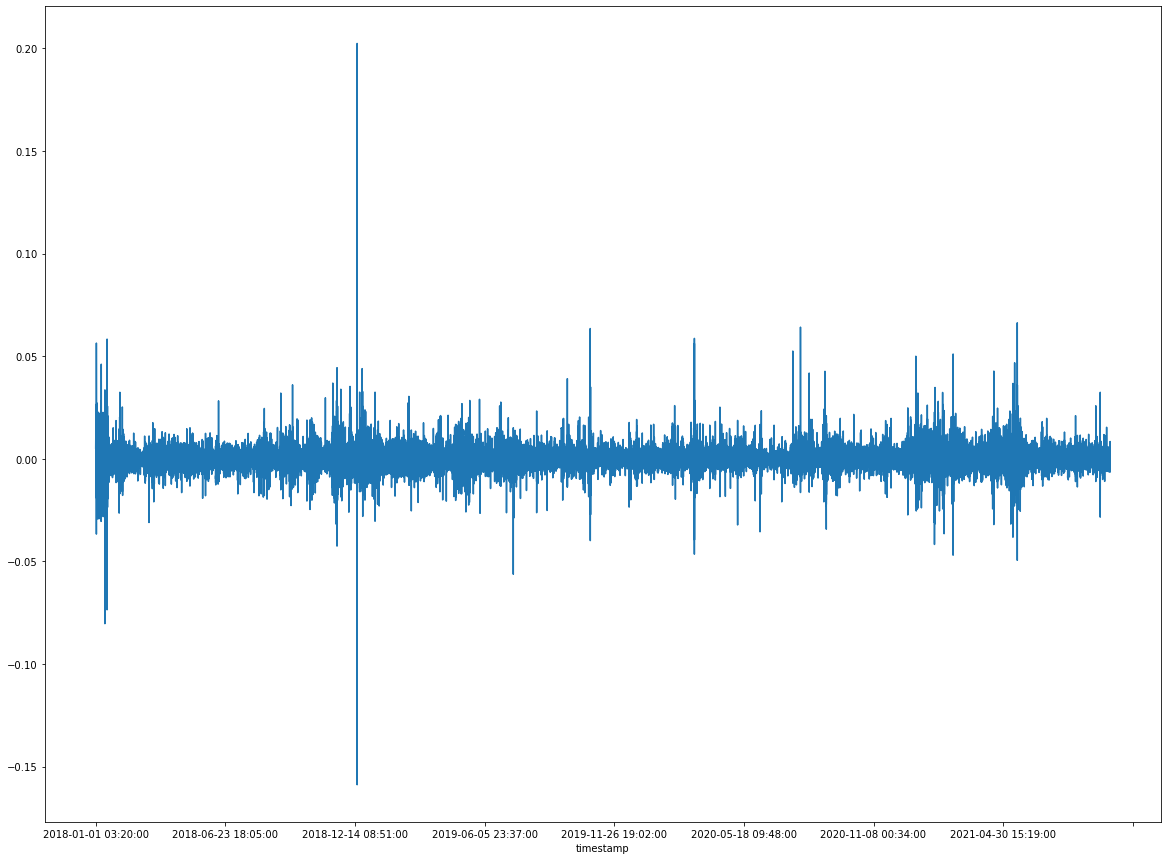

In [11]:
uni_data_df.plot()

In [12]:
uni_data = uni_data_df.values # numpy ndarray from pandas
uni_data

array([ 0.00519134,  0.00447376,  0.00243076, ..., -0.0003459 ,
       -0.0003459 , -0.0003459 ])

In [13]:
TRAIN_SPLIT = 1369506 # First 1369506 (70%)obs will be used as train data and rest as test data.

tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


In [14]:
uni_data

array([ 2.1437673 ,  1.84772018,  1.00484959, ..., -0.14070238,
       -0.14070238, -0.14070238])

## Moving window average

### Pose a simple problem: 
Given last 'k' values of Target-observations (only one feature <=> univariate), predict the next observation

### MWA: 
Average the previous k values to predict the next value.

In [15]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 15
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(1369491, 15, 1)
(1369491,)
(586916, 15, 1)
(586916,)


In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[ 2.1437673 ]
 [ 1.84772018]
 [ 1.00484959]
 [ 1.07823788]
 [ 0.57648749]
 [ 0.16335739]
 [ 0.55326309]
 [ 0.19259373]
 [-0.12681769]
 [-0.07643628]
 [ 0.268663  ]
 [ 0.7514609 ]
 [-0.3019671 ]
 [ 0.10568936]
 [ 0.04821487]]

 Target to predict
0.030021311430455246


In [17]:
#utility function
def create_time_steps(length):
    return list(range(-length, 0))

print(create_time_steps(15))

[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

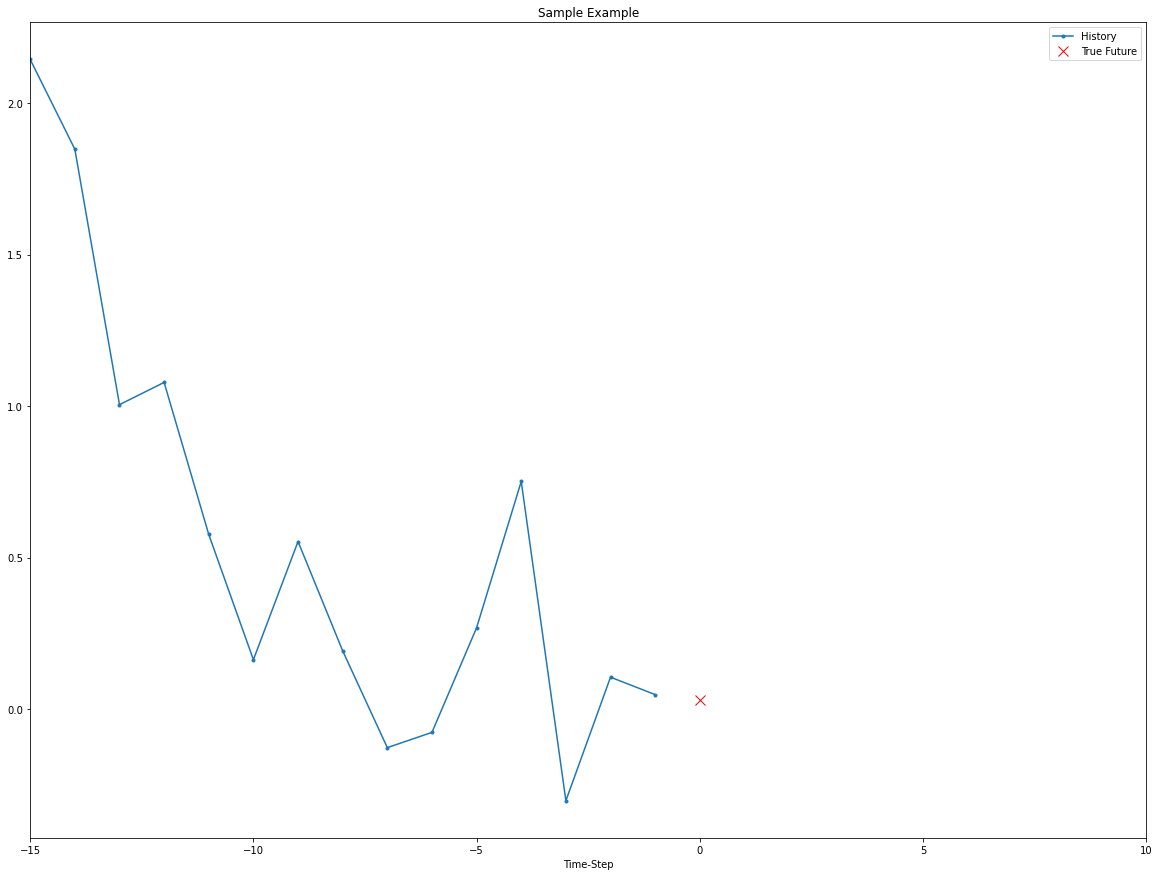

In [18]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
    time_steps = create_time_steps(plot_data[0].shape[0])
  
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

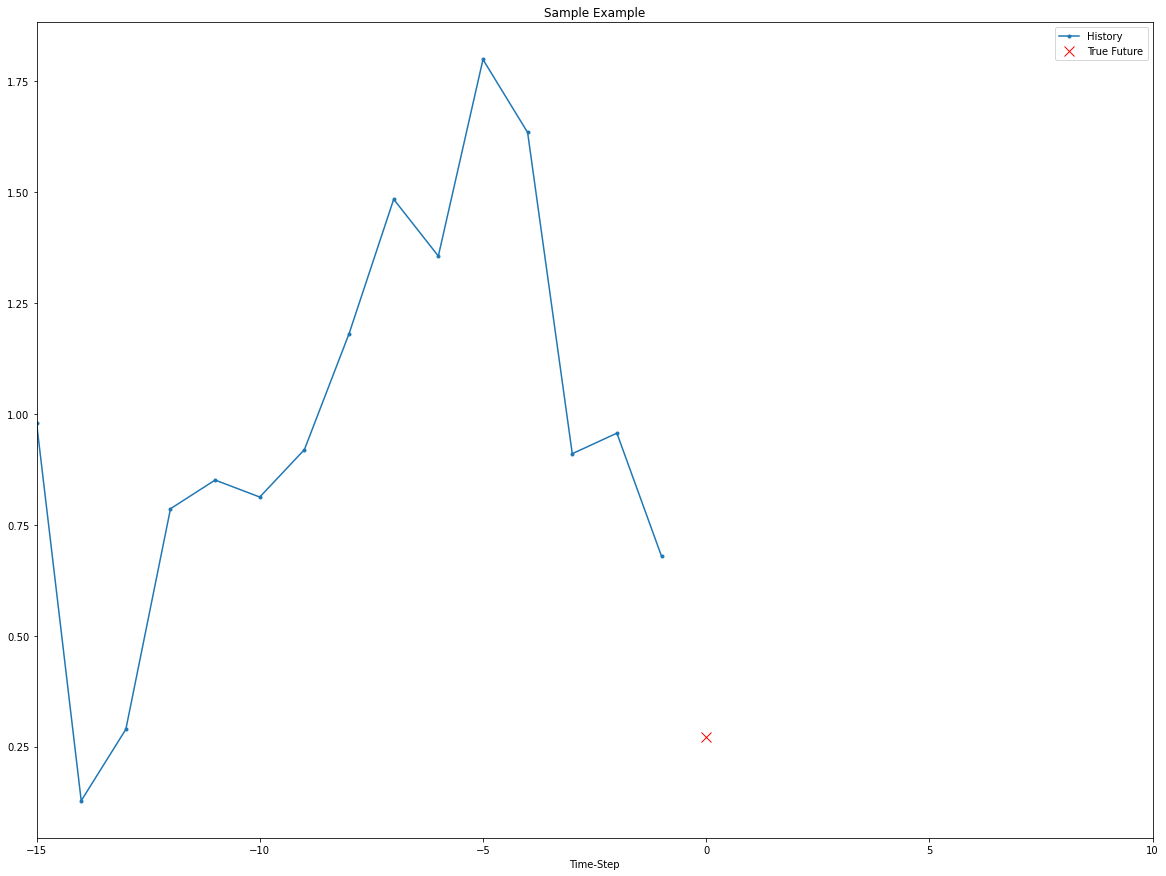

In [19]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [20]:
def mwa(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

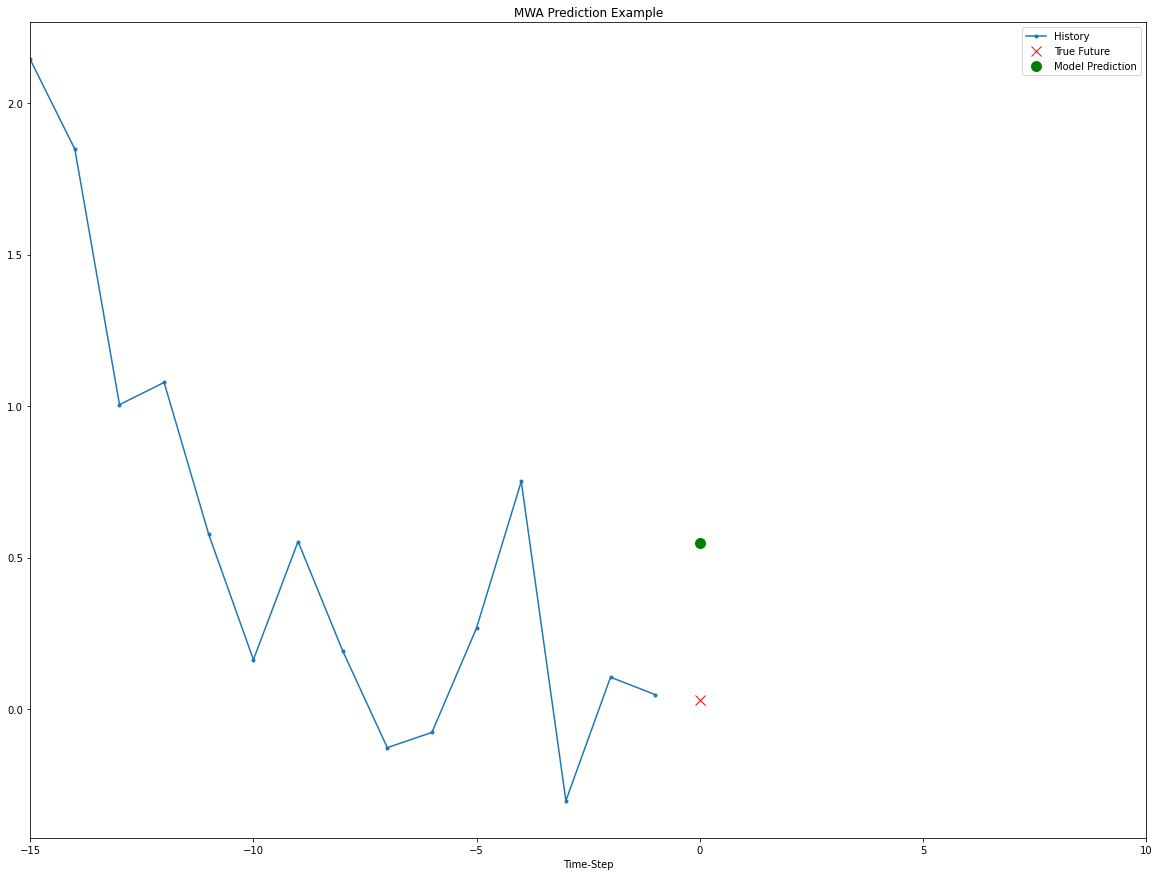

In [21]:
i=0
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

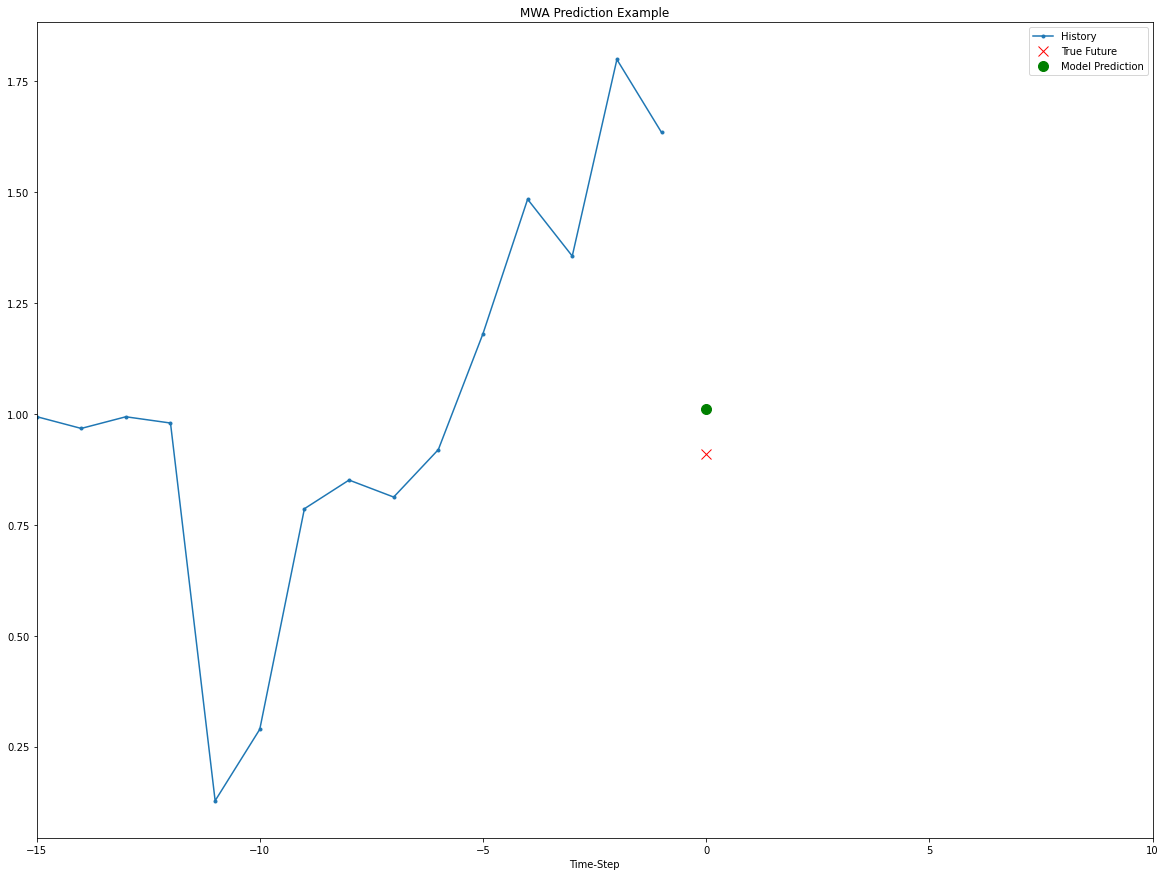

In [22]:
i=17
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

## Univariate time-series forecasting

-  Features from the history: only temperature => univariate

- Problem definition: Given last "k=15" values of target, predict the next target value.

In [23]:
# TF Dataset preperation
BATCH_SIZE = 128 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)

2022-08-09 13:32:38.411831: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 13:32:39.288647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34124 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


<RepeatDataset shapes: ((None, 15, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 15, 1), (None,)), types: (tf.float64, tf.float64)>


In [24]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=x_train_uni.shape[-2:], return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse',metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 13

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model1=model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/13
  1/200 [..............................] - ETA: 15:18 - loss: 8.2622 - mae: 1.9146 - mape: 100.1049

2022-08-09 13:32:57.661078: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


200/200 [==============================] - 24s 97ms/step - loss: 1.5284 - mae: 0.8112 - mape: 509.7520 - val_loss: 0.1030 - val_mae: 0.2356 - val_mape: 237.2964
Epoch 2/13
200/200 [==============================] - 19s 93ms/step - loss: 0.4900 - mae: 0.4941 - mape: 1004.4269 - val_loss: 0.1013 - val_mae: 0.2339 - val_mape: 227.5354
Epoch 3/13
200/200 [==============================] - 19s 94ms/step - loss: 0.2445 - mae: 0.3512 - mape: 314.9747 - val_loss: 0.1033 - val_mae: 0.2364 - val_mape: 207.1167
Epoch 4/13
200/200 [==============================] - 16s 78ms/step - loss: 0.1432 - mae: 0.2698 - mape: 461.7173 - val_loss: 0.0972 - val_mae: 0.2296 - val_mape: 251.8073
Epoch 5/13
200/200 [==============================] - 16s 80ms/step - loss: 0.2347 - mae: 0.3507 - mape: 256.1480 - val_loss: 0.1006 - val_mae: 0.2339 - val_mape: 219.3482
Epoch 6/13
200/200 [==============================] - 19s 93ms/step - loss: 0.1828 - mae: 0.3090 - mape: 565.1620 - val_loss: 0.0983 - val_mae: 0.2310

2022-08-09 13:36:34.815812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [26]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation 
train_pred = model.predict(x_train_uni)

test_pred = model.predict(x_val_uni)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train_uni, y_train_uni, verbose=0)
test_eval = model.evaluate(x_val_uni, y_val_uni, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

KeyboardInterrupt: 

In [ ]:
mean_absolute_percentage_error1(y_train_uni,test_pred)

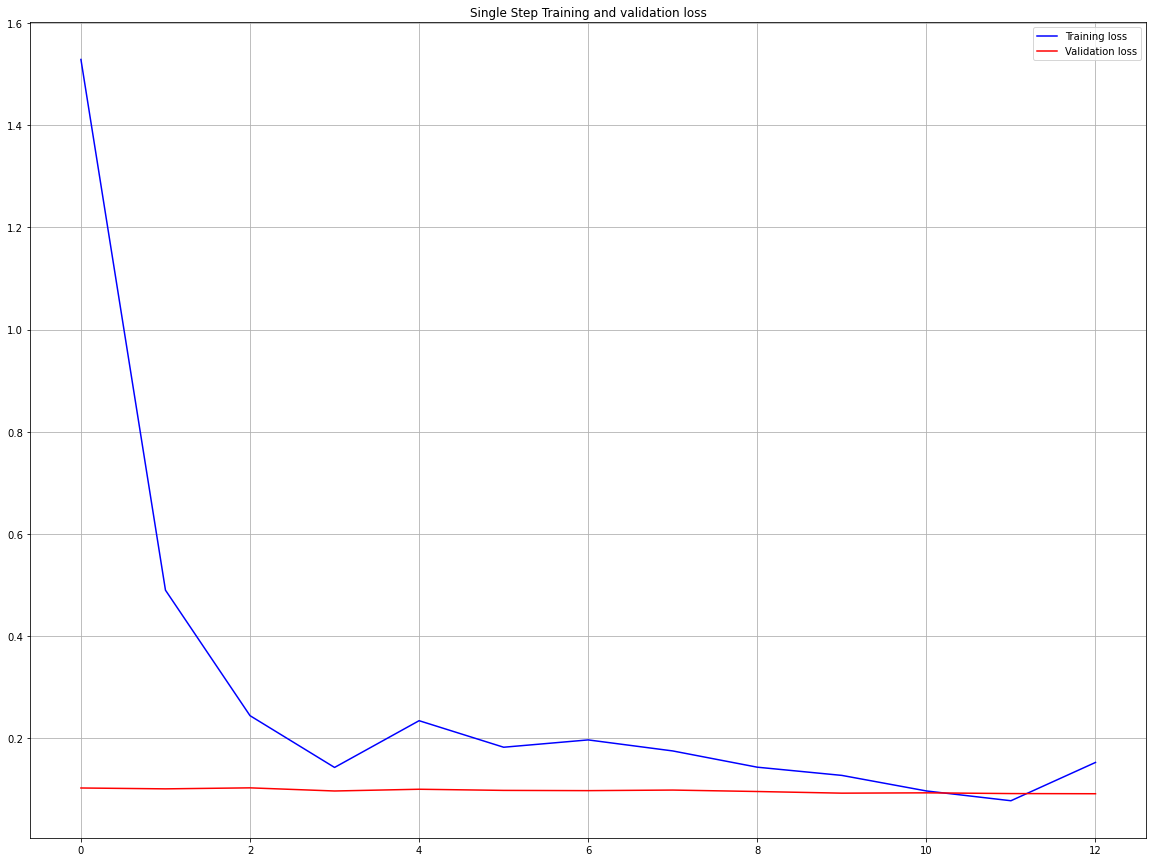

In [27]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.grid()

    plt.show()



plot_train_history(simple_lstm_model1,
                   'Single Step Training and validation loss')

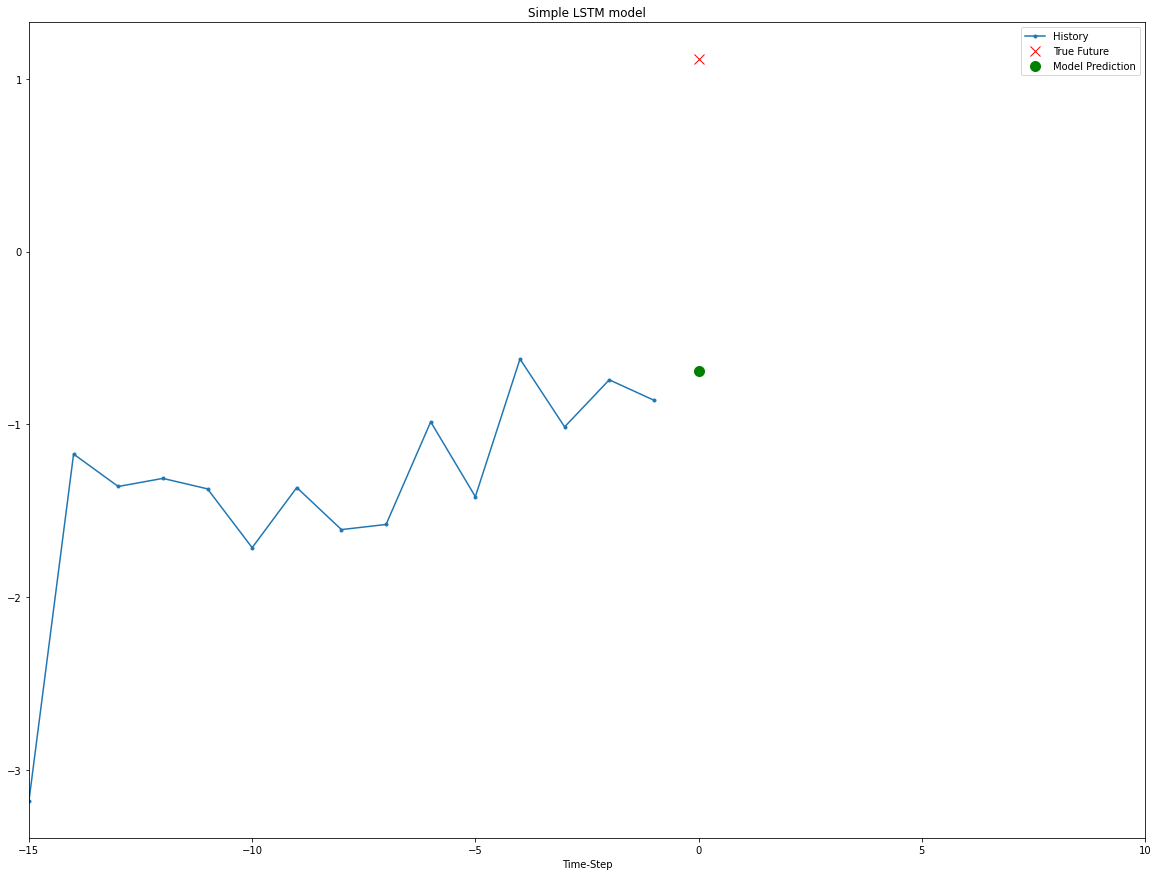

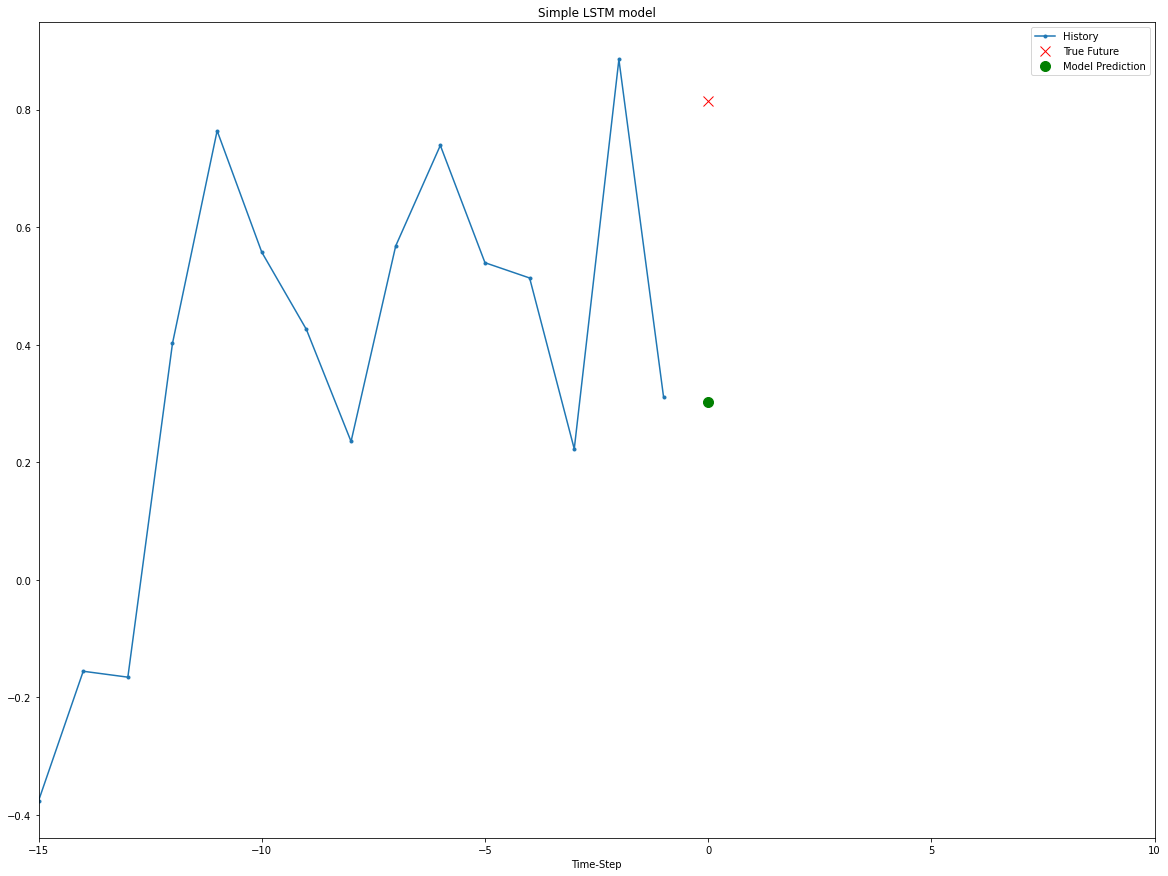

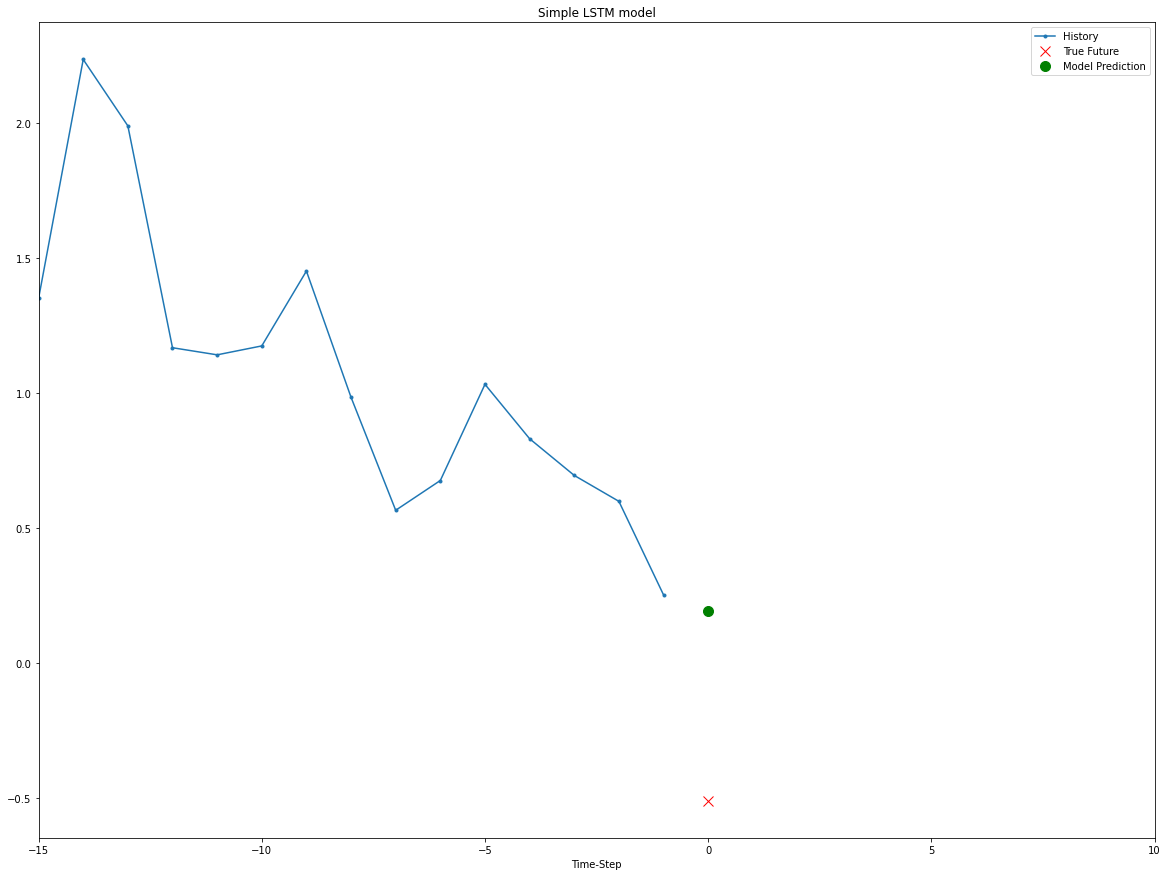

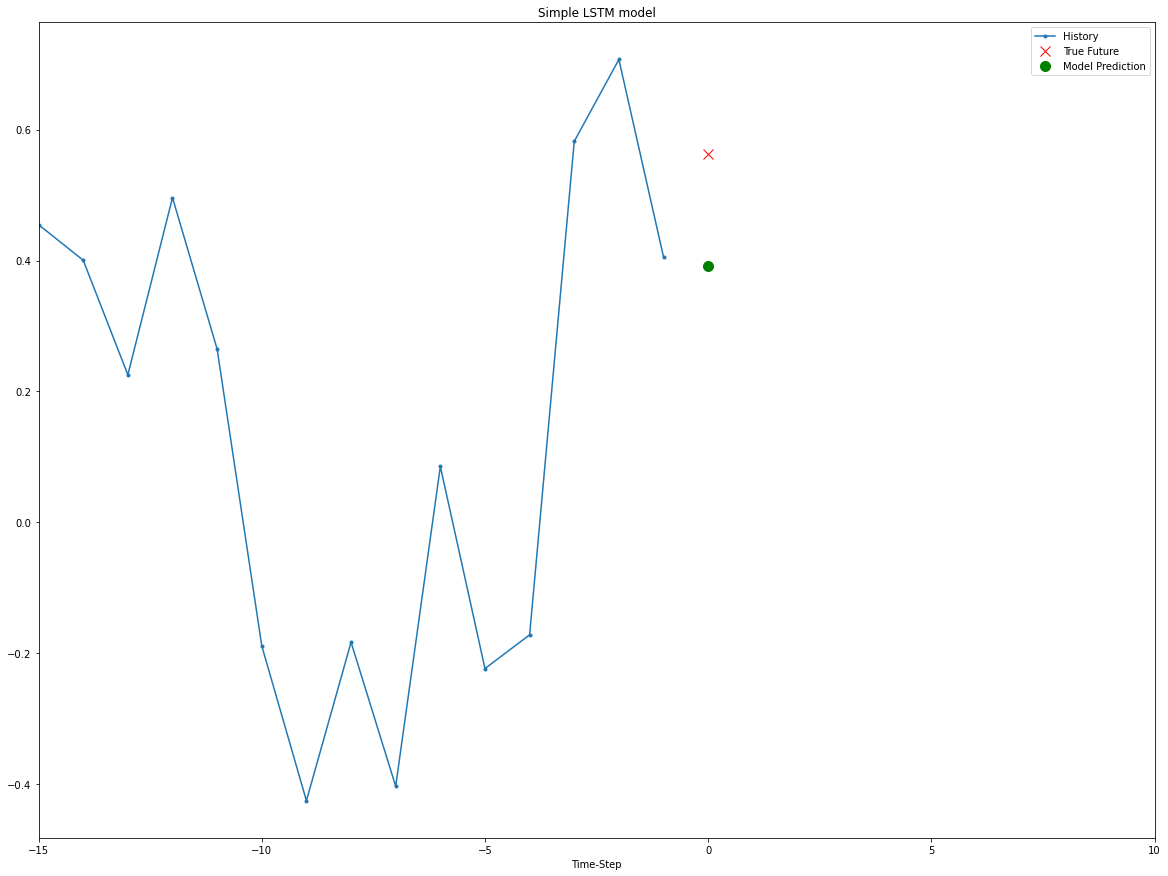

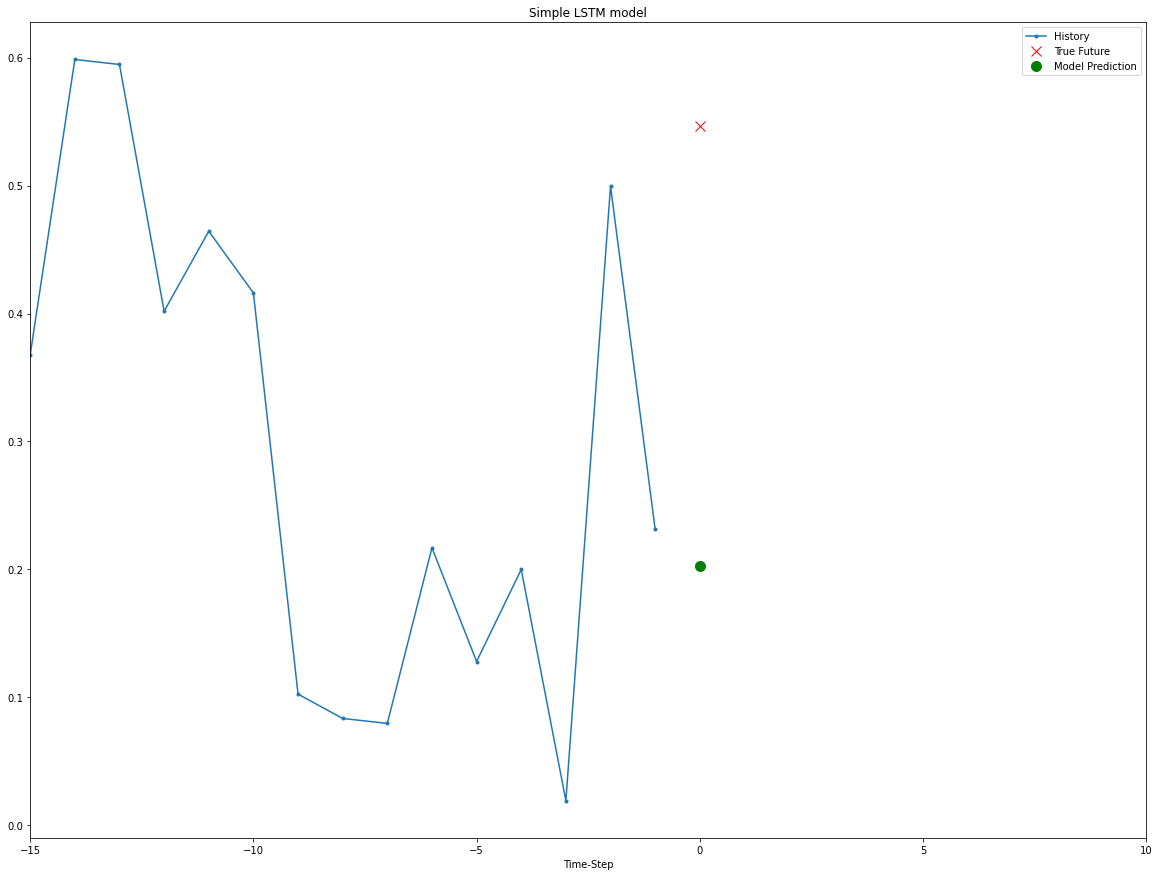

In [28]:
for x, y in val_univariate.take(5): # take 5 random inputs from validation data
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                   model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Multi-variate & single-step forecasting

- Problem definition: Given features at each time stamp in the past, predict the target at a single time-stamp in the future.

In [29]:
df

,timestamp,Count,Open,Final_Target,Close_Diff,DIFF-MA200-MA50,K-ratio,RSI,HL,volatility indicator,trend indicator,Momentum indicator
199,2018-01-01 03:20:00,232.0,732.125000,0.005191,0.962500,3.263417,59.325505,57.991181,13.07,0.017838,0.001402,0.000612
200,2018-01-01 03:21:00,190.0,733.112500,0.004474,-0.682500,3.064079,55.598034,57.154220,11.84,0.016155,-0.000877,-0.000600
201,2018-01-01 03:22:00,119.0,732.605000,0.002431,0.135000,2.881654,56.335336,57.086292,11.71,0.015981,0.000000,-0.000186
202,2018-01-01 03:23:00,157.0,732.632500,0.002609,0.705000,2.701542,60.185691,57.373020,11.79,0.016091,0.000925,0.000794
203,2018-01-01 03:24:00,243.0,733.307500,0.001392,-0.170000,2.501379,58.509455,58.343494,11.29,0.015385,-0.000228,-0.000947
...,...,...,...,...,...,...,...,...,...,...,...,...
1956777,2021-09-20 23:56:00,2162.0,2973.728686,-0.000346,-9.315714,46.753920,41.137309,65.669595,14.01,0.004720,-0.003038,-0.001222
1956778,2021-09-20 23:57:00,1976.0,2965.461446,-0.000346,-3.865714,46.744613,28.626907,47.016489,9.90,0.003341,-0.001558,-0.000895
1956779,2021-09-20 23:58:00,2262.0,2960.321429,-0.000346,-3.447143,46.747439,17.471105,29.078440,8.46,0.002860,-0.000988,-0.000360
1956780,2021-09-20 23:59:00,3594.0,2958.771429,-0.000346,19.791429,46.313896,81.086452,42.394821,21.96,0.007392,0.006200,0.002128


In [30]:
# Features
features_considered = ['Count','Final_Target','Open','Close_Diff','DIFF-MA200-MA50','K-ratio','RSI','HL','volatility indicator','trend indicator','Momentum indicator']

features = df[features_considered]
features.index = df['timestamp']
features.head()

,Count,Final_Target,Open,Close_Diff,DIFF-MA200-MA50,K-ratio,RSI,HL,volatility indicator,trend indicator,Momentum indicator
timestamp,,,,,,,,,,,
2018-01-01 03:20:00,232.0,0.005191,732.1250,0.9625,3.263417,59.325505,57.991181,13.07,0.017838,0.001402,0.000612
2018-01-01 03:21:00,190.0,0.004474,733.1125,-0.6825,3.064079,55.598034,57.154220,11.84,0.016155,-0.000877,-0.000600
2018-01-01 03:22:00,119.0,0.002431,732.6050,0.1350,2.881654,56.335336,57.086292,11.71,0.015981,0.000000,-0.000186
2018-01-01 03:23:00,157.0,0.002609,732.6325,0.7050,2.701542,60.185691,57.373020,11.79,0.016091,0.000925,0.000794
2018-01-01 03:24:00,243.0,0.001392,733.3075,-0.1700,2.501379,58.509455,58.343494,11.29,0.015385,-0.000228,-0.000947


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>], dtype=object)

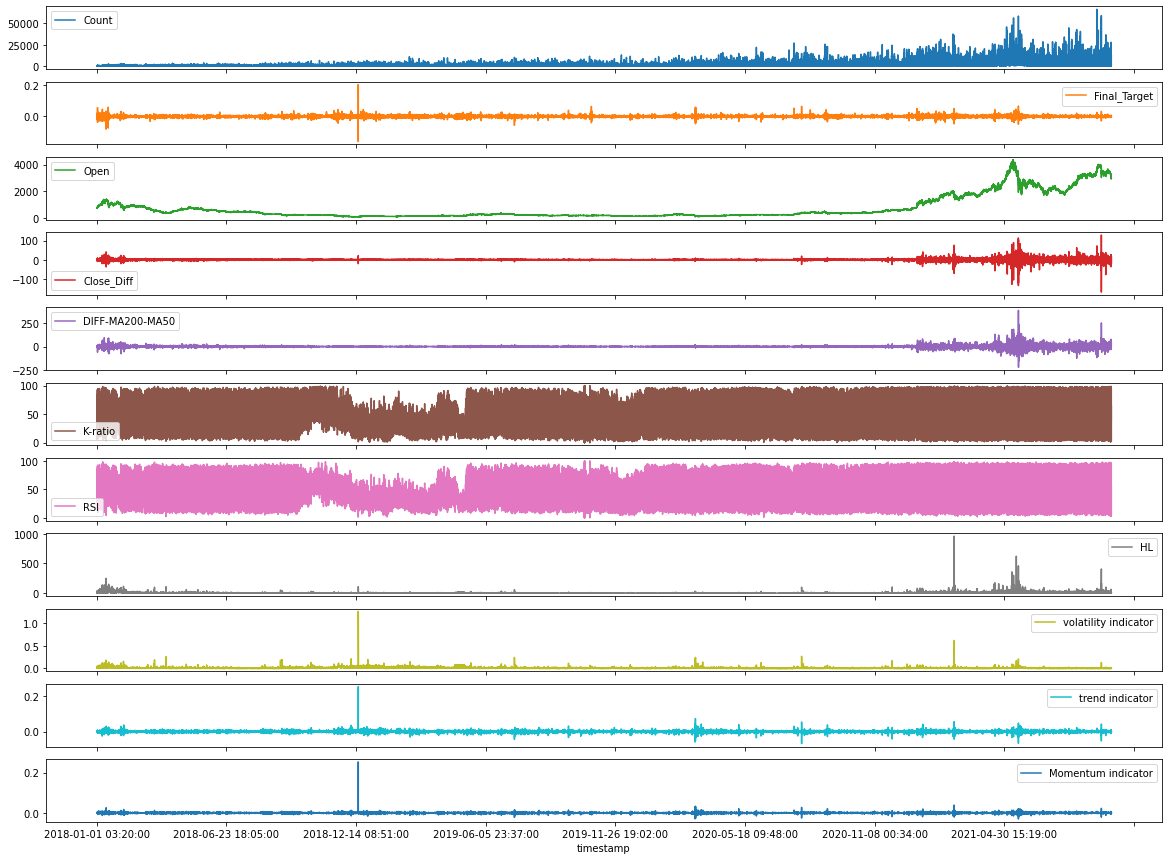

In [31]:
features.plot(subplots=True)

In [34]:
# Standardize data
TRAIN_SPLIT = 1369506
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std
dataset.shape

(1956437, 11)

In [35]:
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 10min, do you want to generate data once evrey 6 steps (60min)
# single_step: lables from single timestamp or multiple timesteps


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) # step used here.
        data.append(dataset[indices])

        if single_step: # single_step used here.
            labels.append(target[i+target_size]) 
        else:
            labels.append(target[i:i+target_size]) 

    return np.array(data), np.array(labels)

In [36]:
# Generate data
past_history = 15 # 60*1 mins 
future_target = 0 # 0*1 mins
STEP = 1 # one obs every 60X1min = 60 min => 1 hr

# past history: 1440 mins => 24 hrs, sampling at one sample evry hours 
# future_target: 0 mins = > 0 hrs in the future, not next hour

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(1369491, 15, 11)
(1369491,)


In [40]:
x_train_single[1,:]

array([[-2.88755849e-01,  1.84772018e+00,  1.82711086e+00,
        -1.09872031e+00,  7.19501019e-01,  4.70676655e-01,
         5.81912083e-01,  1.74330501e+00,  4.85810516e-01,
        -7.29357296e-01, -9.91419763e-01],
       [-4.62661590e-01,  1.00484959e+00,  1.82495489e+00,
         2.17806116e-01,  6.76407978e-01,  5.09616060e-01,
         5.78136089e-01,  1.71837484e+00,  4.71838766e-01,
        -1.17539365e-03, -3.19976810e-01],
       [-3.69585278e-01,  1.07823788e+00,  1.82507172e+00,
         1.13575115e+00,  6.33861204e-01,  7.12966283e-01,
         5.94074760e-01,  1.73371649e+00,  4.80644489e-01,
         7.66864895e-01,  1.26720373e+00],
       [-1.58938888e-01,  5.76487488e-01,  1.82793926e+00,
        -2.73374997e-01,  5.86578152e-01,  6.24438615e-01,
         6.48021466e-01,  1.63783121e+00,  4.23883914e-01,
        -1.90773445e-01, -1.55255698e+00],
       [-8.54575891e-02,  1.63357388e-01,  1.82730203e+00,
         1.88057497e+00,  5.37564764e-01,  9.65314775e-01,
  

In [35]:
df

,timestamp,Count,Open,Final_Target,Close_Diff,DIFF-MA200-MA50,K-ratio,RSI,HL,volatility indicator,trend indicator,Momentum indicator
199,2018-01-01 03:20:00,232.0,732.125000,0.005191,0.962500,3.263417,59.325505,57.991181,13.07,0.017838,0.001402,0.000612
200,2018-01-01 03:21:00,190.0,733.112500,0.004474,-0.682500,3.064079,55.598034,57.154220,11.84,0.016155,-0.000877,-0.000600
201,2018-01-01 03:22:00,119.0,732.605000,0.002431,0.135000,2.881654,56.335336,57.086292,11.71,0.015981,0.000000,-0.000186
202,2018-01-01 03:23:00,157.0,732.632500,0.002609,0.705000,2.701542,60.185691,57.373020,11.79,0.016091,0.000925,0.000794
203,2018-01-01 03:24:00,243.0,733.307500,0.001392,-0.170000,2.501379,58.509455,58.343494,11.29,0.015385,-0.000228,-0.000947
...,...,...,...,...,...,...,...,...,...,...,...,...
1956777,2021-09-20 23:56:00,2162.0,2973.728686,-0.000346,-9.315714,46.753920,41.137309,65.669595,14.01,0.004720,-0.003038,-0.001222
1956778,2021-09-20 23:57:00,1976.0,2965.461446,-0.000346,-3.865714,46.744613,28.626907,47.016489,9.90,0.003341,-0.001558,-0.000895
1956779,2021-09-20 23:58:00,2262.0,2960.321429,-0.000346,-3.447143,46.747439,17.471105,29.078440,8.46,0.002860,-0.000988,-0.000360
1956780,2021-09-20 23:59:00,3594.0,2958.771429,-0.000346,19.791429,46.313896,81.086452,42.394821,21.96,0.007392,0.006200,0.002128


In [1]:
# TF Dataset preperation

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)
train_data_single.head()

NameError: name 'tf' is not defined

In [37]:
# Model

EPOCHS=10

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GRU(8,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dropout(0.2))

single_step_model.add(tf.keras.layers.Dense(1)) # for 72 outputs

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=['mae', 'mape'])

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single,
                                          validation_steps=50)

Epoch 1/10


2022-08-08 21:21:58.858431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


200/200 [==============================] - 8s 19ms/step - loss: 1.4728 - mae: 1.4728 - mape: 518.6781 - val_loss: 0.4104 - val_mae: 0.4104 - val_mape: 629.7143
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.6709 - mae: 0.6709 - mape: 636.6473 - val_loss: 0.3649 - val_mae: 0.3649 - val_mape: 592.0060
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.4098 - mae: 0.4098 - mape: 671.6451 - val_loss: 0.3118 - val_mae: 0.3118 - val_mape: 430.8362
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3029 - mae: 0.3029 - mape: 260.9141 - val_loss: 0.2822 - val_mae: 0.2822 - val_mape: 359.2085
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.3821 - mae: 0.3821 - mape: 1580.5525 - val_loss: 0.2549 - val_mae: 0.2549 - val_mape: 249.1818
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.3289 - mae: 0.3289 - mape: 385.7063 - val_loss: 0.2480 - val_mae: 0.2480 - val

2022-08-08 21:22:31.933438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation 
train_pred1 = single_step_model.predict(x_train_single)

test_pred1 = single_step_model.predict(x_val_single)

#Print evaluation metrics for all datasets
train_eval1 = single_step_model.evaluate(x_train_single, y_train_single, verbose=0)
test_eval1 = single_step_model.evaluate(x_val_single, y_val_single, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval1[0], train_eval1[1], train_eval1[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval1[0], test_eval1[1], test_eval1[2]))

 
Evaluation metrics
Training Data - Loss: 0.4016, MAE: 0.4016, MAPE: 401.0605
Test Data - Loss: 0.4398, MAE: 0.4398, MAPE: 325.4426


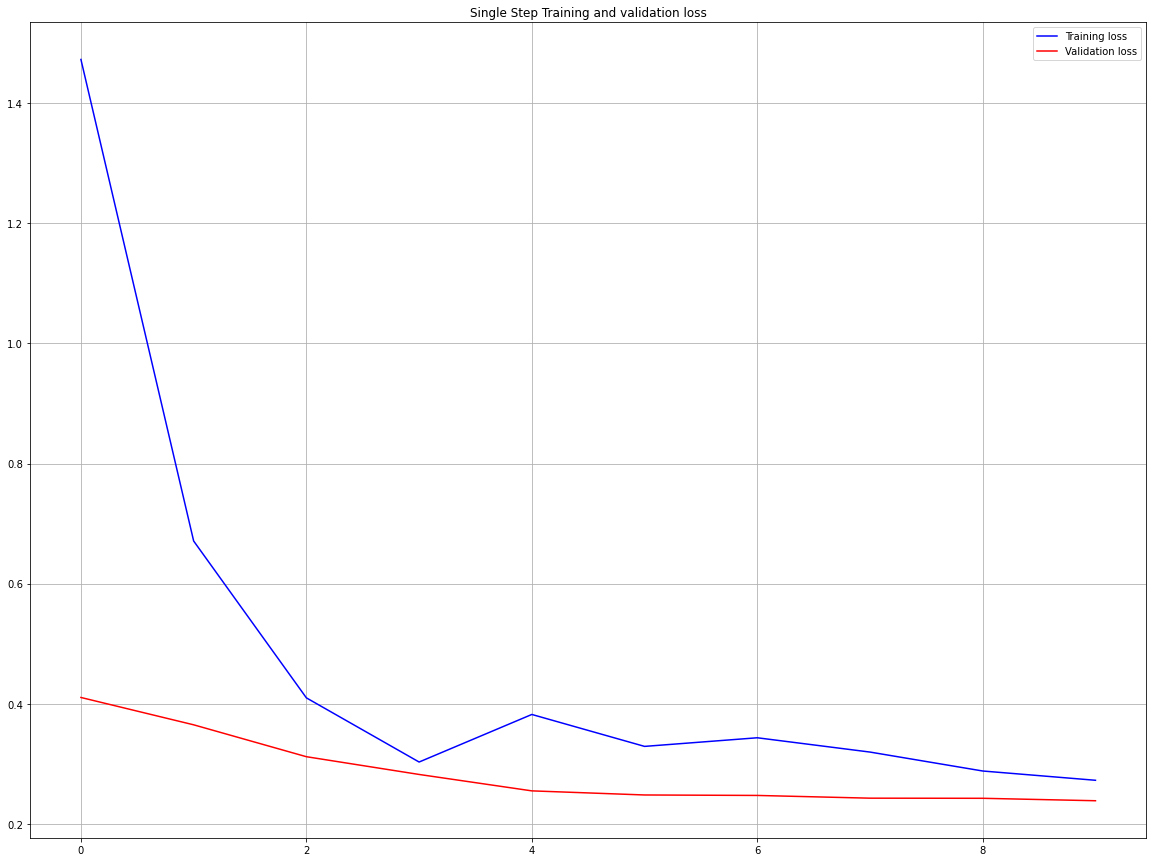

In [40]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

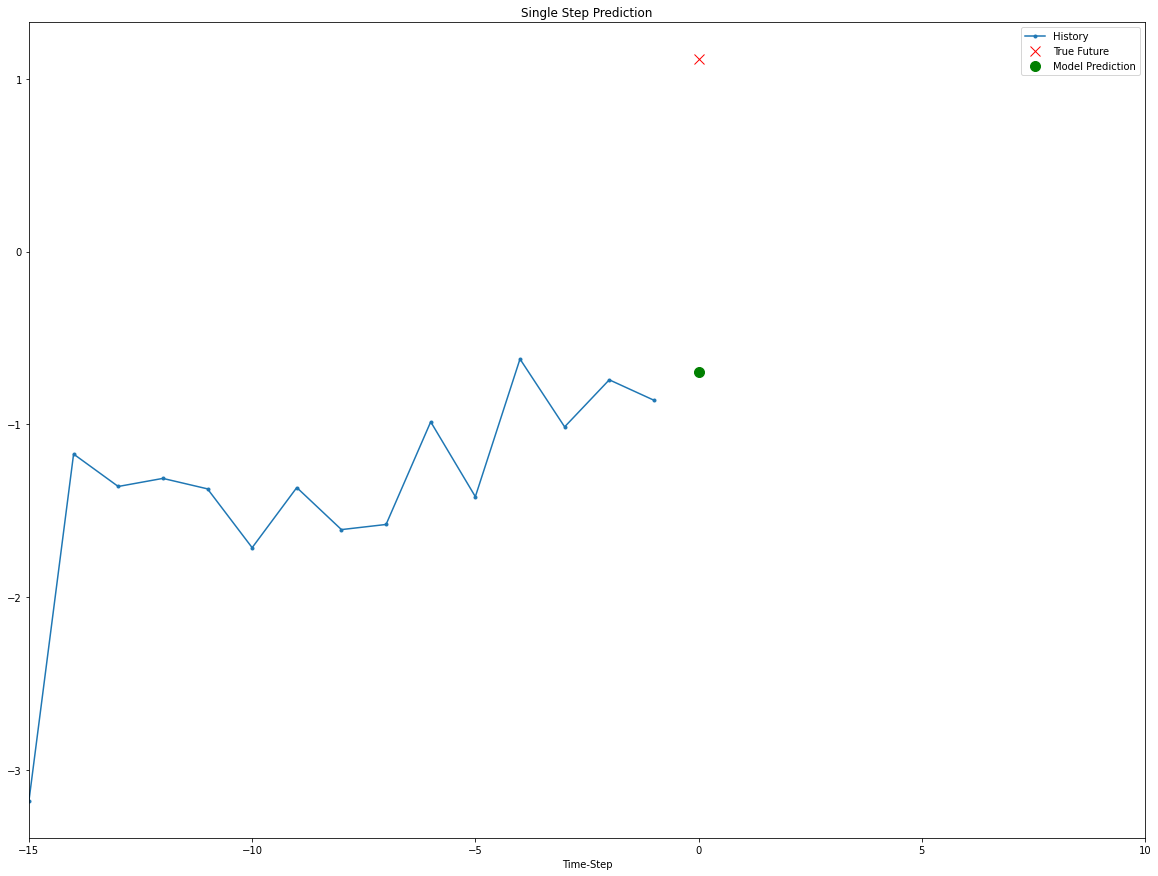

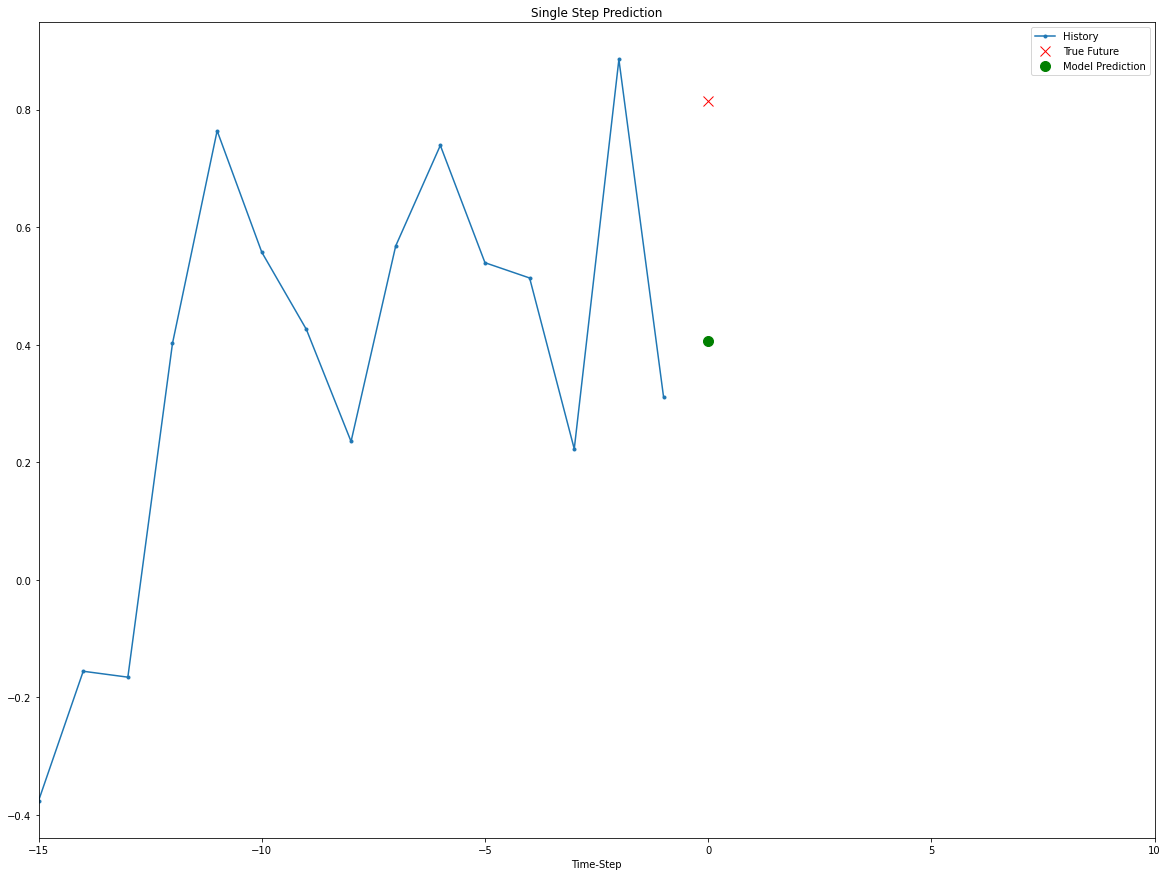

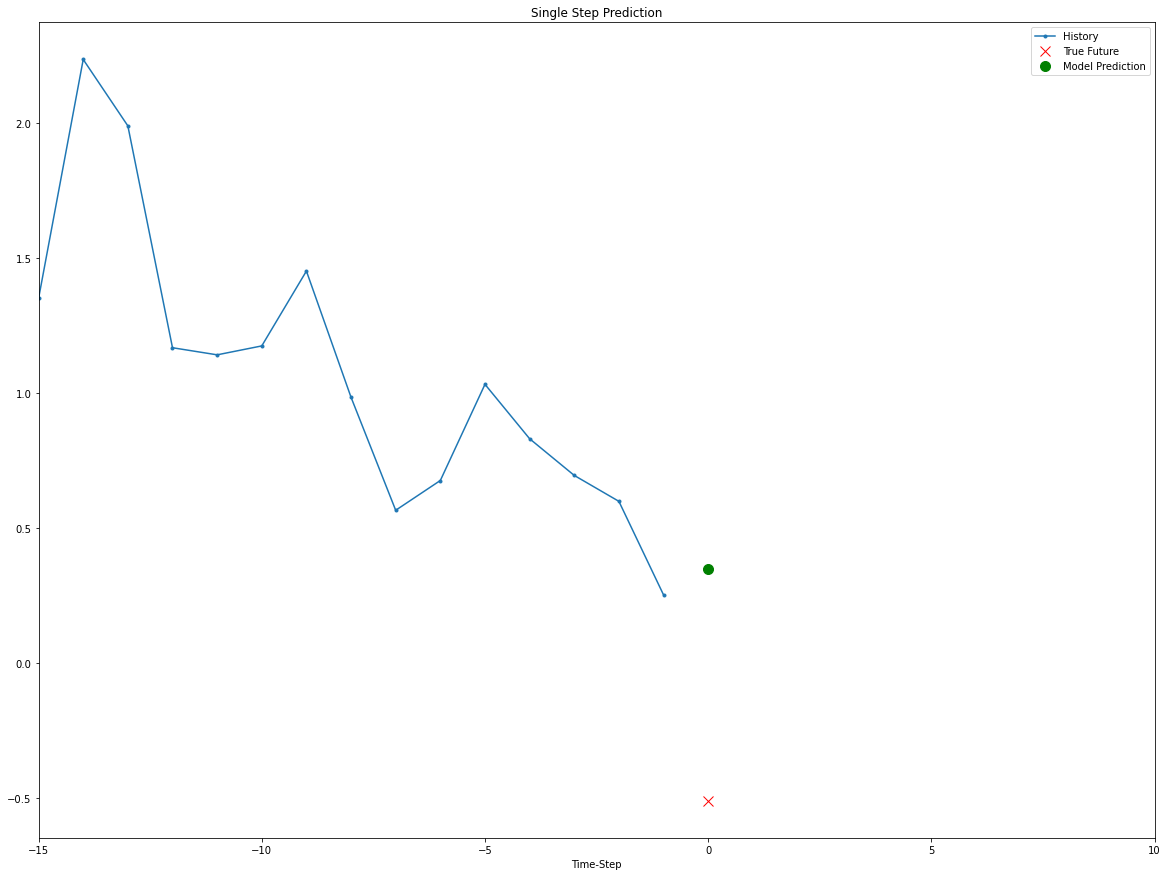

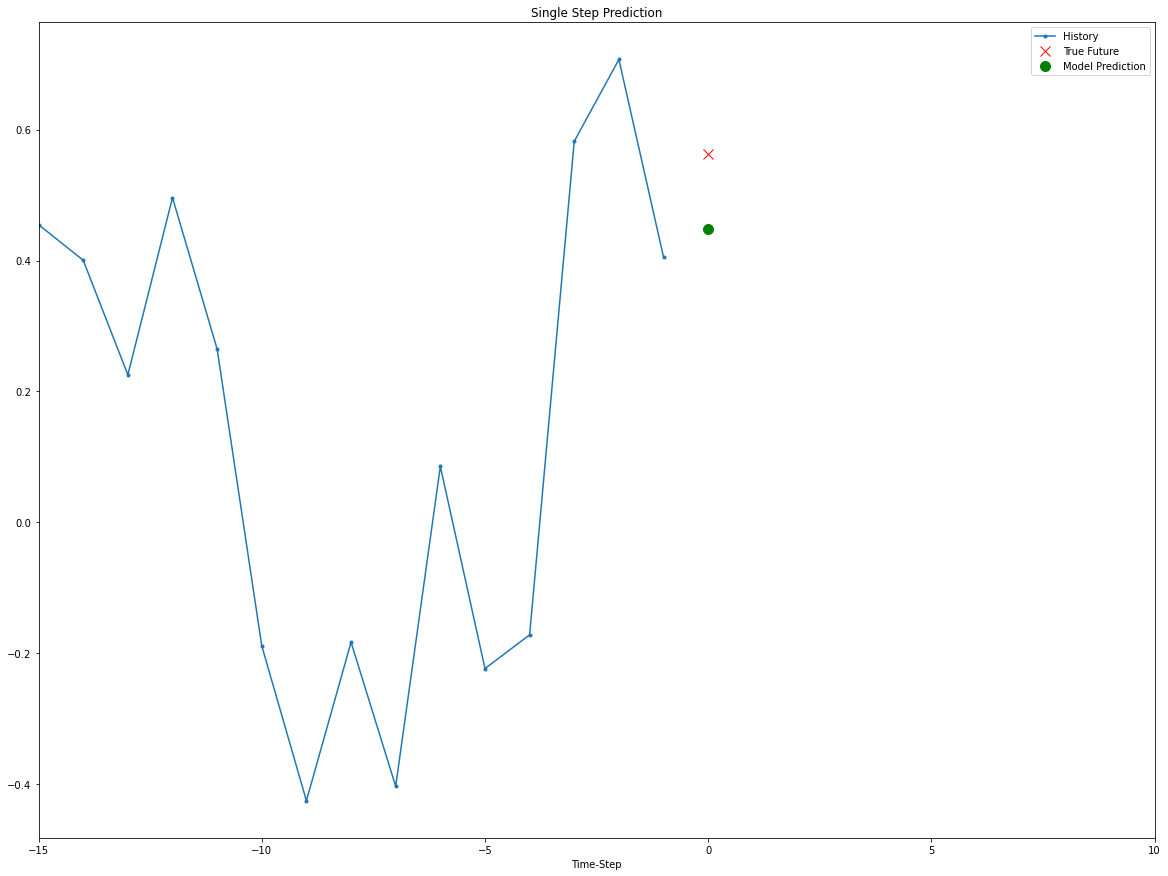

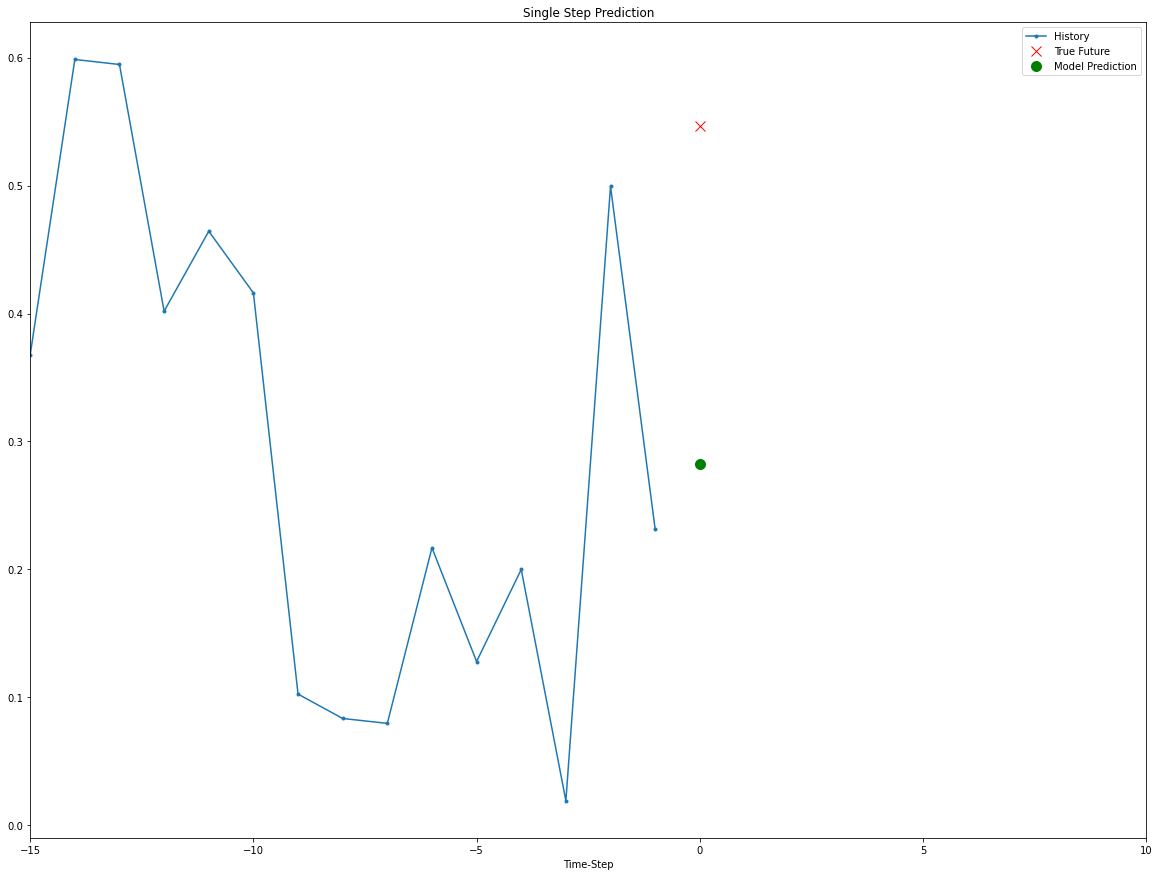

In [41]:
# plot time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 0,
                   'Single Step Prediction')
  plot.show()

## Multi-variate & multi-step forecasting
- Generate multiple future values of target

In [42]:
# single_step=FALSE default value

future_target = 15 # 15 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(1369491, 15, 11)
(1369491, 15)
(586901, 15, 11)
(586901, 15)


In [43]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

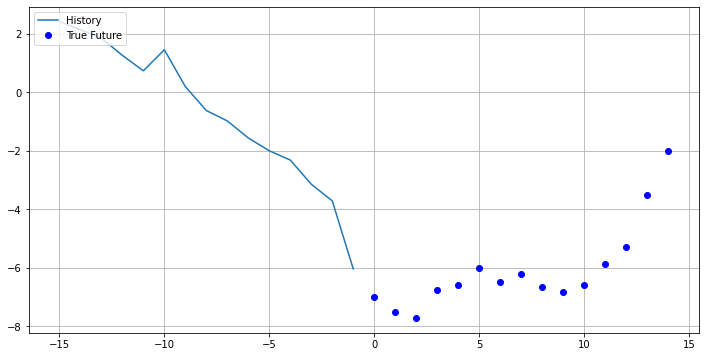

2022-08-08 21:37:00.415657: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [44]:
#plotting function
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.grid()
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
  


for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [45]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.GRU(16,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.GRU(8, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(15)) # for 15 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=['mae', 'mape'])

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 17s 66ms/step - loss: 1.5216 - mae: 1.5216 - mape: 240.0045 - val_loss: 0.5194 - val_mae: 0.5194 - val_mape: 350.3642
Epoch 2/10
200/200 [==============================] - 13s 64ms/step - loss: 0.8130 - mae: 0.8130 - mape: 410.5431 - val_loss: 0.4815 - val_mae: 0.4815 - val_mape: 334.0964
Epoch 3/10
200/200 [==============================] - 13s 63ms/step - loss: 0.5522 - mae: 0.5522 - mape: 287.8690 - val_loss: 0.4730 - val_mae: 0.4730 - val_mape: 311.3851
Epoch 4/10
200/200 [==============================] - 13s 64ms/step - loss: 0.4536 - mae: 0.4536 - mape: 350.2335 - val_loss: 0.4623 - val_mae: 0.4623 - val_mape: 287.8370
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.5955 - mae: 0.5955 - mape: 786.9716 - val_loss: 0.4545 - val_mae: 0.4545 - val_mape: 269.7545
Epoch 6/10
200/200 [==============================] - 10s 52ms/step - loss: 0.5191 - mae: 0.5191 - mape: 443.8270 - val_loss: 0.4527 - val_m

2022-08-08 21:39:57.333941: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [46]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation 
train_pred2 = multi_step_model.predict(x_train_multi)

test_pred2 = multi_step_model.predict(x_val_multi)

#Print evaluation metrics for all datasets
train_eval2 = multi_step_model.evaluate(x_train_multi, y_train_multi, verbose=0)
test_eval2 = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval2[0], train_eval2[1], train_eval2[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval2[0], test_eval2[1], test_eval2[2]))

 
Evaluation metrics
Training Data - Loss: 0.5837, MAE: 0.5837, MAPE: 360.1524
Test Data - Loss: 0.6453, MAE: 0.6453, MAPE: 310.3227


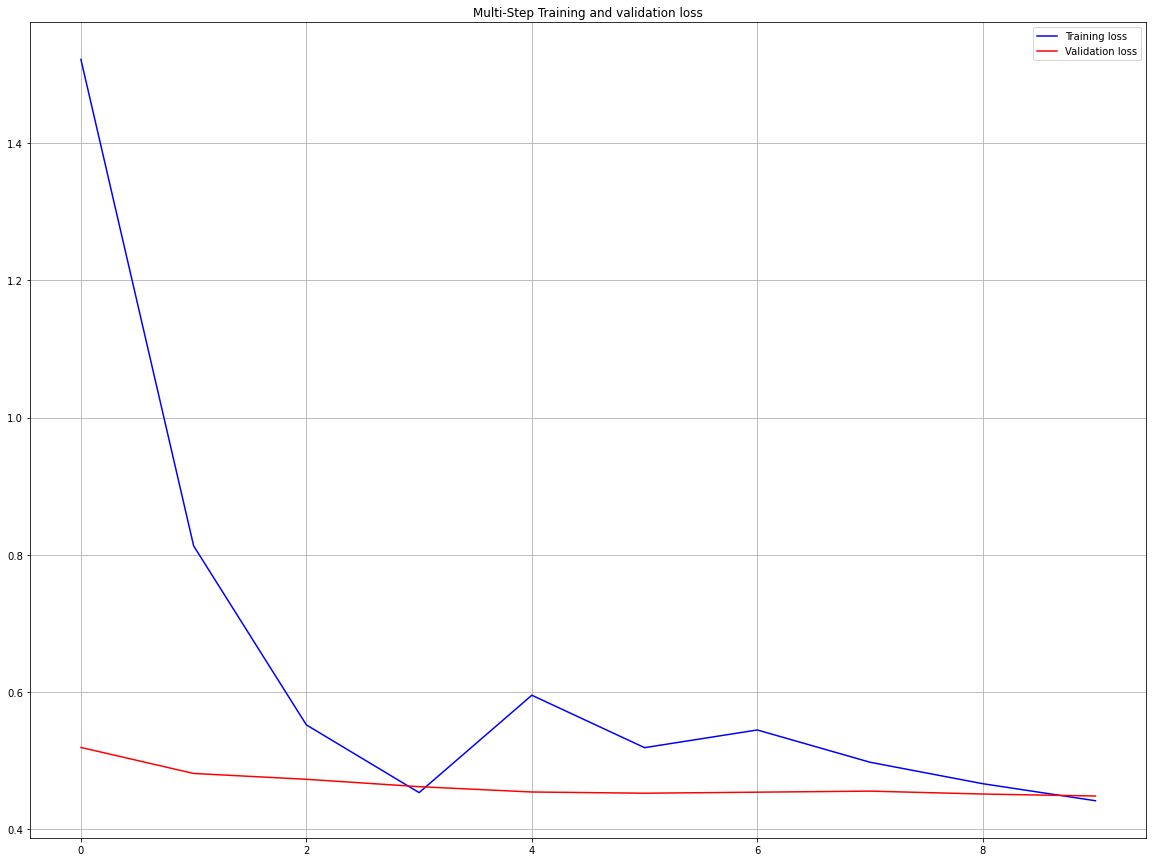

In [47]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

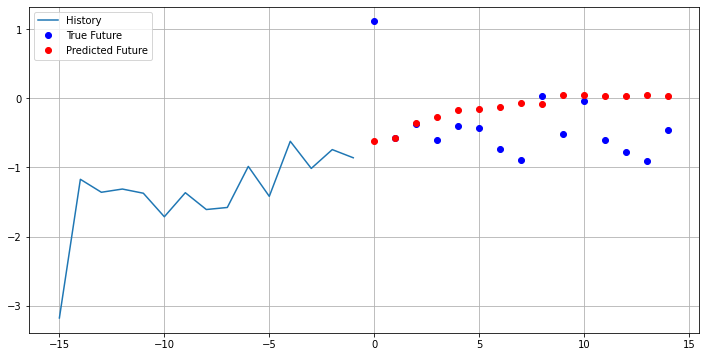

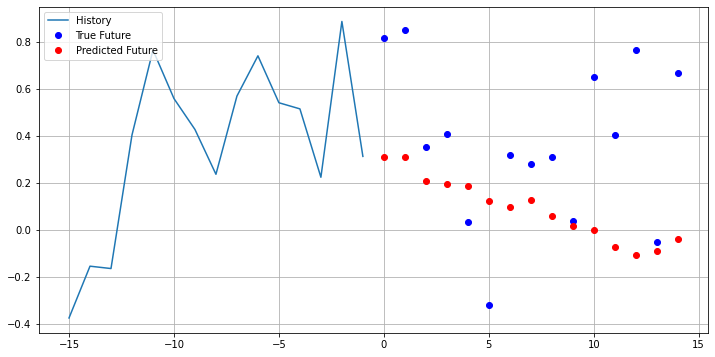

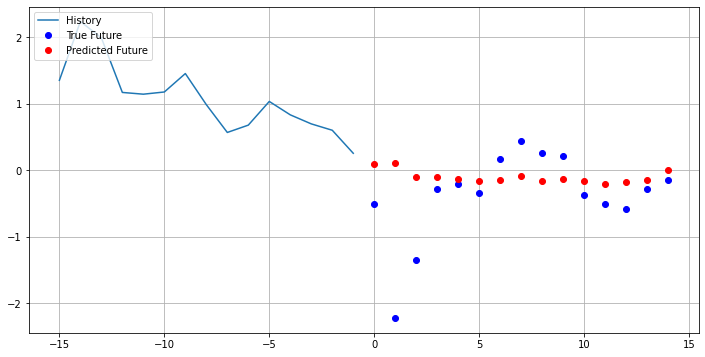

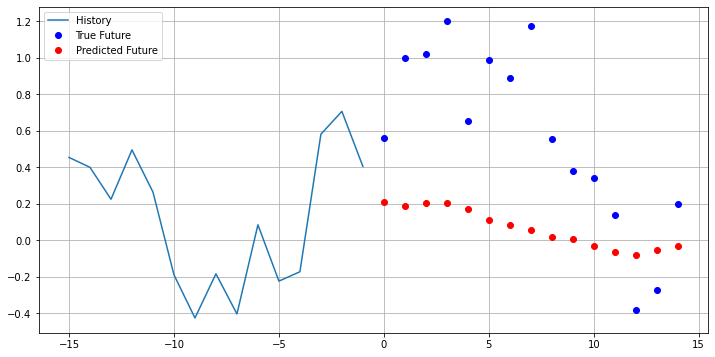

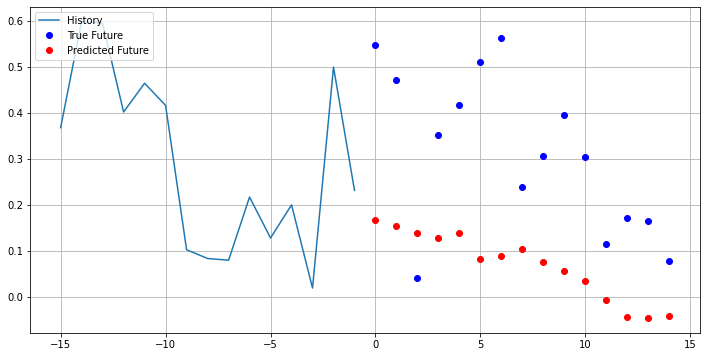

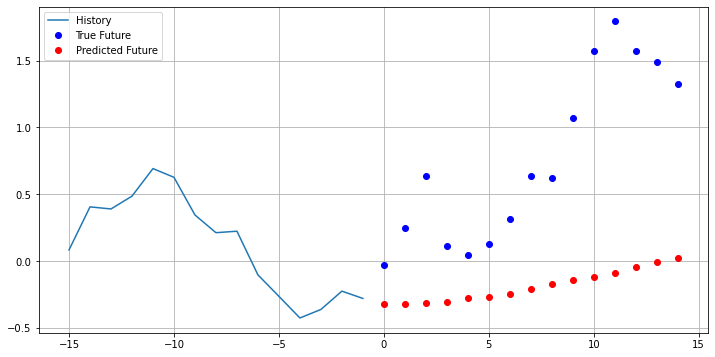

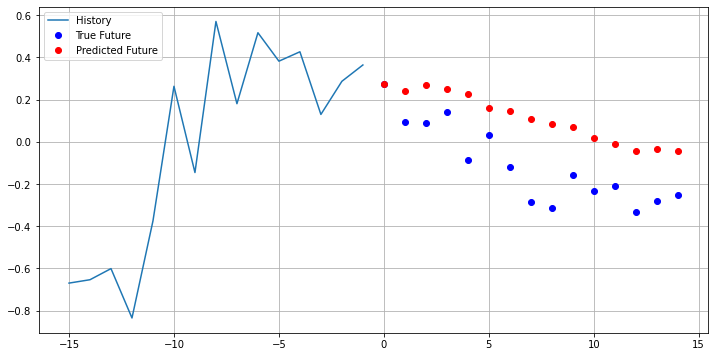

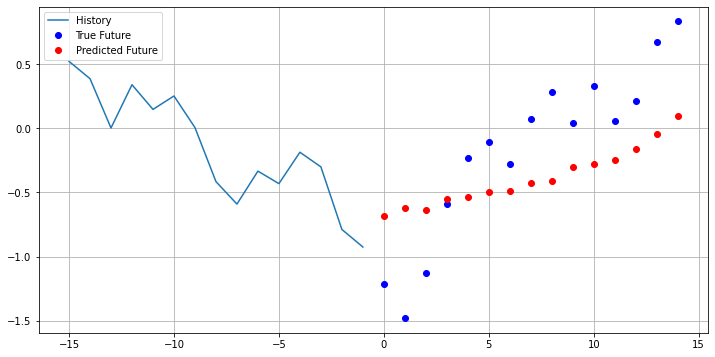

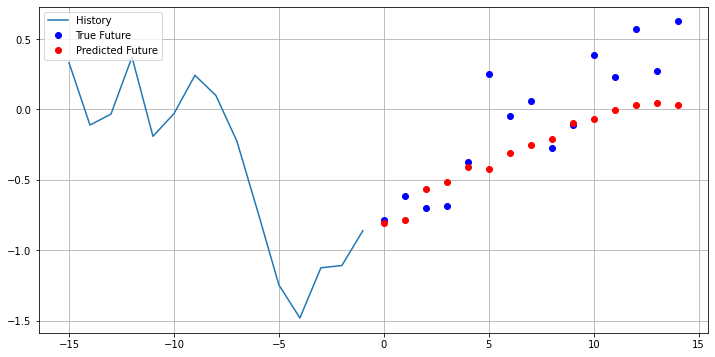

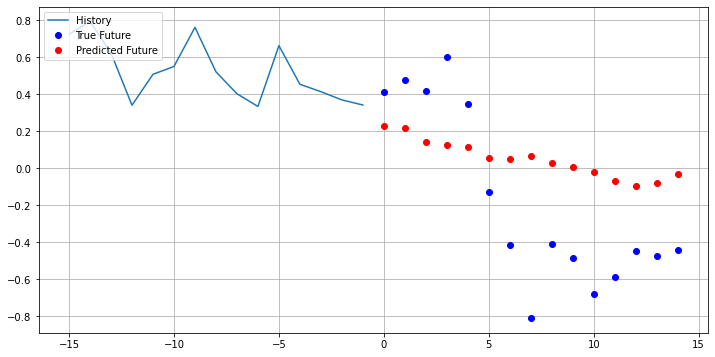

In [48]:
for x, y in val_data_multi.take(10):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])